# prepare

## git clone

In [1]:
!git clone https://github.com/kc71486/autonomous_hw2.git
%cd autonomous_hw2

Cloning into 'autonomous_hw2'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 40 (delta 2), reused 12 (delta 1), pack-reused 26
Unpacking objects: 100% (40/40), 44.60 MiB | 8.43 MiB/s, done.
/content/autonomous_hw2


## pip install

In [2]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=84b75ee48022dd1f0d129bb7480ce0f9eac359fba8f789bfcff36c7d4396e1e4
  Stored in directory: /root/.cache/pip/wheels/1d/57/24/4eff6a03a9ea0e647568e8a5a0546cdf957e3cf005372c0245
Successfully built ffmpeg


# main

## import

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

import math
import os

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## helper functions

In [7]:
def ratio_to_coord(img, ratio=[0, 0]):
    xsize = image.shape[1];
    ysize = image.shape[0];
    return [int(xsize*ratio[0]), int(ysize*ratio[1])];
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color  
    # added [] in vertices  
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## lane finding algirithm

In [8]:
def process_image(img):

    grayimg = grayscale(img);

    blur_gray = gaussian_blur(grayimg, 5);
    low_threshold = 30;
    high_threshold = 100;
    edges = canny(blur_gray, low_threshold, high_threshold);
    
    left = ratio_to_coord(image, [0.0, 0.9]);
    right = ratio_to_coord(image, [1.0, 0.9]);
    left_bottom = ratio_to_coord(image, [0.0, 1.0]);
    right_bottom = ratio_to_coord(image, [1.0, 1.0]);
    left_top = ratio_to_coord(image, [0.4, 0.5]);
    right_top = ratio_to_coord(image, [0.6, 0.5]);
    vertices = np.array([[left_bottom, left, left_top, right_top, right, right_bottom]])
    masked_edges = region_of_interest(edges, vertices);

    rho = 1;
    theta = np.pi/180;
    threshold = 15;
    min_line_length = 10;
    max_line_gap = 2;

    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap);
    final_img = weighted_img(line_image, img)

    return final_img;

## Process sample image

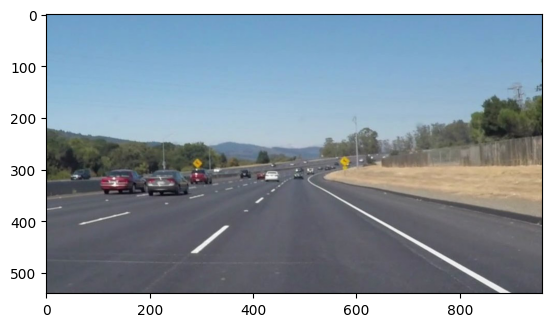

In [9]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg');

#printing out some stats and plotting
plt.imshow(image);  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

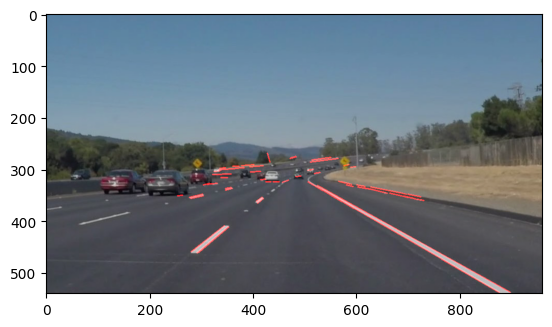

In [10]:
newimage = process_image(image)
plt.imshow(newimage, cmap='Greys_r')

## convert video

In [11]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 3.61 s, sys: 412 ms, total: 4.02 s
Wall time: 21.2 s


In [12]:
#not supported in any of my browser though
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## git commit and push

In [16]:
f = open("../remotepath.txt", "r");
remote_path = f.readline();

In [18]:
!git config --global user.email "linda20030102@gmail.com"
!git config --global user.name "kc71486"
!git remote set-url origin {remote_path}

In [ ]:
!git add "test_videos_output/solidWhiteRight.mp4"
!git commit -m "add output solidWhiteRight.mp4"

In [ ]:
!git push origin main

Enumerating objects: 6, done.
Counting objects: 100% (6/6), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1.31 MiB | 2.32 MiB/s, done.
Total 4 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/kc71486/autonomous_hw2.git
   e7359bf..4338e9e  main -> main
